In [10]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
% matplotlib inline

In [4]:
mnist = input_data.read_data_sets('../data/mnist', one_hot=True) 

Extracting ../data/mnist/train-images-idx3-ubyte.gz
Extracting ../data/mnist/train-labels-idx1-ubyte.gz
Extracting ../data/mnist/t10k-images-idx3-ubyte.gz
Extracting ../data/mnist/t10k-labels-idx1-ubyte.gz


In [20]:
#practice
"""
a = tf.random_normal(shape=[10])
with tf.Session() as sess:
    print sess.run(a)
sess.close()
"""
a = tf.random_normal(shape=[4, 3])
b = tf.reduce_sum(a, axis=1)
c = a/tf.reshape(b, [4, 1])
with tf.Session() as sess:
    print sess.run(a)
    print sess.run(b)
    print sess.run(c)
sess.close()

[[-1.24291623 -1.43309152 -0.63831836]
 [ 0.99006844  0.78328633 -0.39547479]
 [-0.94146031  0.38000315  0.49025828]
 [-0.67146844 -1.68480265 -0.68875319]]
[ 0.37187165 -1.08423734 -0.11929947 -0.99239534]
[[-0.04340046  0.65374619  0.38965428]
 [ 0.96231061 -1.37524915  1.41293859]
 [ 0.52968073 -0.335673    0.80599225]
 [ 1.42050338 -0.34518328 -0.07532015]]


Extracting ../data/mnist/train-images-idx3-ubyte.gz
Extracting ../data/mnist/train-labels-idx1-ubyte.gz
Extracting ../data/mnist/t10k-images-idx3-ubyte.gz
Extracting ../data/mnist/t10k-labels-idx1-ubyte.gz
step :1000


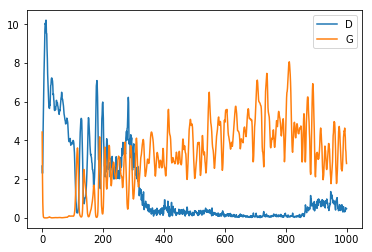

step :2000


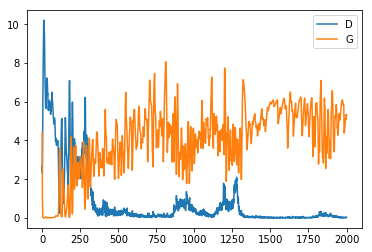

step :3000


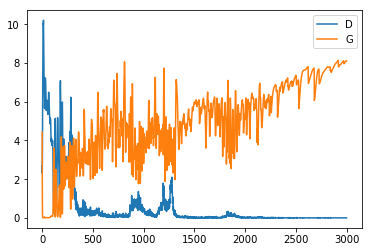

step :4000


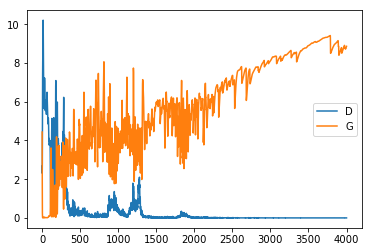

step :5000


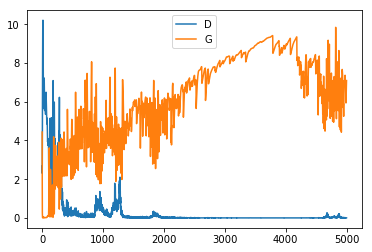

step :6000


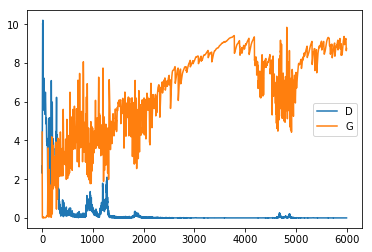

step :7000


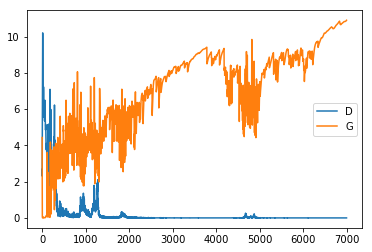

step :8000


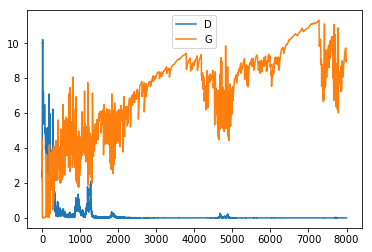

step :9000


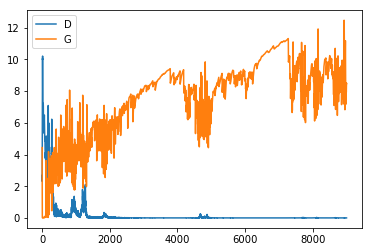

step :10000


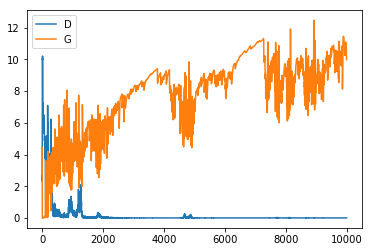

step :11000


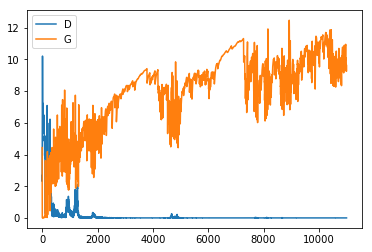

step :12000


KeyboardInterrupt: 

In [36]:
#GAN作っていく

#データ格納場所
X = tf.placeholder(tf.float32, shape=[None, 28*28])

#パラメータの初期化
def init_param(size):
    init_params = tf.random_normal(shape=size)
    init_norm = tf.reduce_sum(init_params**2, axis=1)**0.5
    init_params_normalization =  init_params/tf.reshape(init_norm, [size[0], 1])
    return init_params_normalization

#descriminator
D_W1 = tf.Variable(init_param([28*28, 14*14]))
D_b1 = tf.Variable(tf.zeros(shape=[14*14]))

D_W2 = tf.Variable(init_param([14*14, 7*7]))
D_b2 = tf.Variable(tf.zeros(shape=[7*7]))

D_W3 = tf.Variable(init_param([7*7, 1]))
D_b3 = tf.Variable(tf.zeros(shape=[1]))

theta_D = [D_W3, D_W2, D_W1, D_b3, D_b2, D_b1]

def descriminator(x):
    D_h1 = tf.nn.relu(tf.matmul(x, D_W1) + D_b1)
    D_h2 = tf.nn.relu(tf.matmul(D_h1, D_W2) + D_b2)
    D_logit = tf.matmul(D_h2, D_W3) + D_b3
    D_prob = tf.nn.sigmoid(D_logit)
    
    return D_prob, D_logit

#generator
Z = tf.placeholder(tf.float32, shape=[None, 100])

G_W1 = tf.Variable(init_param([100, 14*14]))
G_b1 = tf.Variable(tf.zeros(shape=[14*14]))

G_W2 = tf.Variable(init_param([14*14, 20*20]))
G_b2 = tf.Variable(tf.zeros(shape=[20*20]))

G_W3 = tf.Variable(init_param([20*20, 28*28]))
G_b3 = tf.Variable(tf.zeros(shape=[28*28]))

theta_G = [G_W3, G_W2, G_W1, G_b3, G_b2, G_b1]

def sample_Z(m, n):
    return np.random.uniform(-1.0, 1.0, size=[m, n])

def generator(z):
    G_h1 = tf.nn.relu(tf.matmul(z, G_W1) + G_b1)
    G_h2 = tf.nn.relu(tf.matmul(G_h1, G_W2) + G_b2)
    G_logit = tf.matmul(G_h2, G_W3) + G_b3
    G_prob = tf.nn.sigmoid(G_logit)
    
    return G_prob

#visualization
def plot(sample):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig

#algorithm

G_sample = generator(Z)
D_real, D_logit_real = descriminator(X)
D_fake, D_logit_fake = descriminator(G_sample)

D_loss_real = tf.reduce_mean((tf.nn.sigmoid_cross_entropy_with_logits(
                                 logits=D_logit_real, labels=tf.ones_like(D_logit_real))))
D_loss_fake = tf.reduce_mean((tf.nn.sigmoid_cross_entropy_with_logits(
                                 logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake))))
D_loss = D_loss_real+D_loss_fake

G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                                 logits=D_logit_fake, labels=tf.ones_like(D_logit_fake)))

D_solver = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(D_loss, var_list=theta_D)
G_solver = tf.train.AdamOptimizer(learning_rate=0.001).minimize(G_loss, var_list=theta_G)

#satting parameter
mb_size = 128
Z_dim = 100
step = 1000000
D_loss_list = []
G_loss_list = []

#deta
mnist = input_data.read_data_sets('../data/mnist', one_hot=True) 

#data_save
if not os.path.exists('../data/GAN_fig/'):
    os.makedirs('../data/GAN_fig/')

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    i = 0
    for _iter in range(step):
        if _iter % 1000 == 0:
            samples = sess.run(G_sample, feed_dict={Z: sample_Z(16, Z_dim)})

            fig = plot(samples)
            plt.savefig('../data/GAN_fig/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')
            i += 1
            plt.close(fig)
    
        X_mb, _ = mnist.train.next_batch(mb_size)

        _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={X: X_mb, Z: sample_Z(mb_size, Z_dim)})
        _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={Z: sample_Z(mb_size, Z_dim)})
        
        D_loss_list.append(D_loss_curr)
        G_loss_list.append(G_loss_curr)

        if _iter % 1000 == 0 and _iter >0:
            print 'step :{}'.format(_iter)
            plt.plot(np.arange(_iter+1), D_loss_list, label="D")
            plt.plot(np.arange(_iter+1), G_loss_list, label="G")
            plt.legend()
            plt.show()